# Triton Inference Server Simple Local Test

NVIDIA Triton client를 사용하여 서버가 수신 대기 중인 localhost:8000(http)이나 localhost:8001(grpc)으로 요청을 보냅니다.

In [1]:
import json
import numpy as np
import tritonclient.http as httpclient
import tritonclient.grpc as grpcclient
from utils.inference_lib import encode_image, decode_image
    
def setup_triton_httpclient(url="localhost"):

    try:
        triton_client = httpclient.InferenceServerClient(
            url=f"{url}:8000",
            verbose=False,
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def setup_triton_grpcclient(url="localhost"):

    try:
        triton_client = grpcclient.InferenceServerClient(
            url=f"{url}:8001",
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def get_sample_binary_httpclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(httpclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(httpclient.InferRequestedOutput("generated_image", binary_data=True))

    return inputs, outputs


def get_sample_binary_grpcclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(grpcclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(grpcclient.InferRequestedOutput("generated_image"))

    return inputs, outputs

In [2]:
CONTAINER_ID=!docker container ls -q
FIRST_CONTAINER_ID = CONTAINER_ID[0]

In [5]:
!docker logs $FIRST_CONTAINER_ID


== Triton Inference Server ==

NVIDIA Release 23.05 (build <unknown>)
Triton Server Version 2.34.0

Copyright (c) 2018-2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

NOTE: CUDA Forward Compatibility mode ENABLED.
  Using CUDA 12.1 driver version 530.30.02 with kernel driver version 525.85.12.
  See https://docs.nvidia.com/deploy/cuda-compatibility/ for details.

I0815 06:03:20.716683 1 cache_manager.cc:478] Create CacheManager with cache_dir: '/opt/tritonserver/caches'
I0815 06:03:20.888304 1 pinned_memory_manager.cc:240] Pinned memory pool is created at '0x7f7f50000000' with size 268435456
I0815 06:03:20.890394 1 cuda_m

<br>

## 1. httpclient
---

### Initializt triton client

In [6]:
triton_client = setup_triton_httpclient()

### Prepare input data

In [7]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

inputs, outputs = get_sample_binary_httpclient(payload)

### Inference

CPU times: user 1.91 ms, sys: 24 µs, total: 1.93 ms
Wall time: 3.9 s


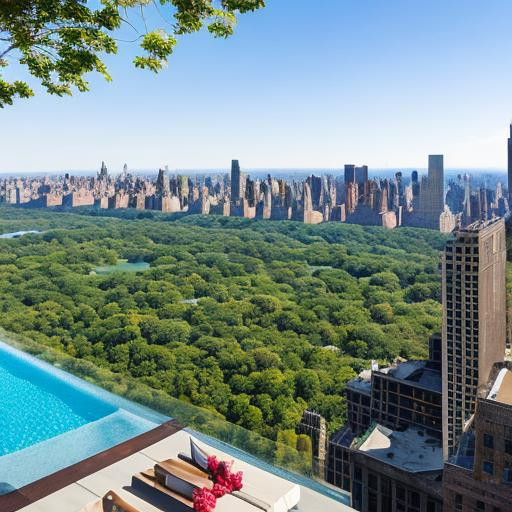

In [9]:
%%time
model_name = "sd_base"
results = triton_client.infer(
    model_name,
    inputs,
    outputs=outputs,
    headers=None
)

output_image = results.as_numpy('generated_image')
decode_image(output_image[0].decode('utf-8'))

<br>

## 2. grpcclient
---

### Initializt triton client

In [10]:
triton_client = setup_triton_grpcclient()

### Prepare input data

In [11]:
inputs, outputs = get_sample_binary_grpcclient(payload)

### Inference

CPU times: user 3.16 ms, sys: 410 µs, total: 3.57 ms
Wall time: 3.9 s


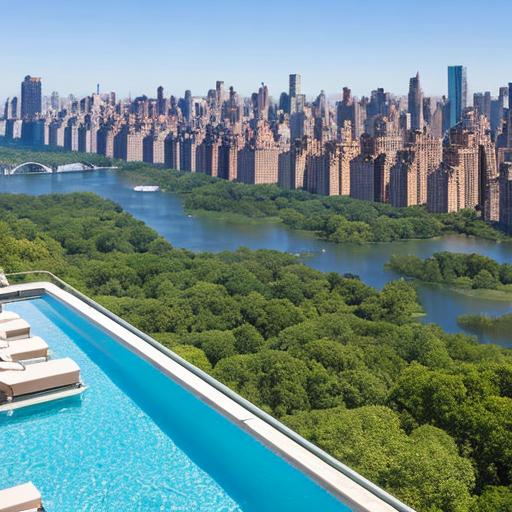

In [12]:
%%time
model_name = "sd_base"
results = triton_client.infer(
    model_name,
    inputs,
    outputs=outputs,
    headers=None
)

output_image = results.as_numpy('generated_image')
decode_image(output_image[0].decode('utf-8'))